# Introduction

here I'll take the data fitted from the experiments and use it to predict the emergent respiration

In [25]:
using Pkg

Pkg.activate("..")

using DifferentialEquations
using Plots
using GLM
using DelimitedFiles

const k = 8.617e-5;

Activating environment at `~/Documents/Work/Projects/Working/Bacterial_Interactions/Project.toml`


In [26]:
#read in data
R_data = readdlm("../data/Francisca/Processed/R_params.csv",',')
u_data = readdlm("../data/Francisca/Processed/u_params.csv",',')
pair_data = readdlm("../data/Francisca/Processed/pairs_params.csv",',')
Com_data = readdlm("../data/Francisca/Processed/Com_params.csv",',');

pair_data[:,[1,2,4,5,6,7]]

21×6 Array{Any,2}:
   "OTU_1"    "OTU_2"          "N0"    "E"        "r0_norm"    "r_p_min"
 15         18          8098000      -0.125385   0.650051    -0.523245  
 15         18          4477100      -0.136991   0.490862    -0.523245  
 15         20         11750000      -0.0703341  0.63895     -0.523245  
 15         20         11067100      -0.248315   0.392135    -0.523245  
 15         23          6625000      -0.0758919  0.723792    -0.523245  
 15         23          3563620      -0.198027   0.470551    -0.523245  
 18         20          6527000      -0.116644   0.608772    -0.523245  
 18         20          6830900      -0.234357   0.446592    -0.523245  
 18         23          3930000      -0.241898   0.725168    -0.523245  
 18         23          2059900      -0.266186   0.509443    -0.523245  
  2         15          5917000      -0.169395   0.720125    -0.523245  
  2         15          4940000      -0.116923   0.716322    -0.523245  
  2         18          4974000 

In [30]:
#define ODE system and problem
function dC!(dC,C,p,t)
    for i = 1:p[:N]
        dC[i] = C[i] * p[:r][i]
        for j = 1:p[:N]
            dC[i] += C[i]*C[j] * p[:a][i,j]
        end
    end
end

function param_gen(Temp::Float64,Treatment::String)
    #check the treatment is correctly entered
    @assert Treatment ∈ ["Evolved","Nonevolved"]

    #get resp rates
    R_subset = hcat([R_data[x,[1,3,4]] for x = 1:size(R_data)[1] if R_data[x,2] == Treatment]...)'
    indx = sortperm(R_subset[:,1])
    R_vals = (R_subset[:,2] .* exp.(R_subset[:,3] .* Temp))[indx]
           
    #get growth rates
    u_subset = hcat([u_data[x,[1,4,5,6]] for x = 1:size(u_data)[1] if u_data[x,2] == Treatment]...)'
    indx = sortperm(u_subset[:,1])  
    u_vals = (u_subset[:,3] .* exp.(u_subset[:,2] .* Temp) )[indx]
    
     N = length(indx)
    #get interactions
    
    #combined growth rate prediction
    pair_subset = hcat([pair_data[x,[1,2,4,5,6,7]] for x = 1:size(pair_data)[1] if pair_data[x,3] == Treatment]...)'
    pair_u_vals = pair_subset[:,5] .* exp.(pair_subset[:,4] .* Temp) #paired growth
     
    #Get indicies of pair combos 
    indx_1 = pair_subset[:,1]
    indx_2 = pair_subset[:,2]
             
    indx_ind_1 = [findall(x .== u_subset[:,1])[1] for x = indx_1]
    indx_ind_2 = [findall(x .== u_subset[:,1])[1] for x = indx_2]
          
    #get pair growth             
    u_1 = u_vals[indx_ind_1]                
    u_2 = u_vals[indx_ind_2] 
    
    a = ((2 * pair_u_vals) .- u_1 .- u_2) ./ pair_subset[:,3]
    a_mat = zeros(N,N)
    
    for i = 1:length(a)
        a_mat[indx_ind_1[i],indx_ind_2[i]] = a[i]
        a_mat[indx_ind_2[i],indx_ind_1[i]] = a[i]
    end
                    
    #generate dict
    p = Dict(:R => R_vals,
             :r => u_vals,
             :a => a_mat,
             :N => N)
                    
    return(p)
end
                                    
function get_resp(sol,nT)
    x = [sol.prob.p[:R] .* sol(t) for t in range(sol.t[1],sol.t[end],length=nT)]
    return(map(sum,x))
end
                                    

get_resp (generic function with 1 method)

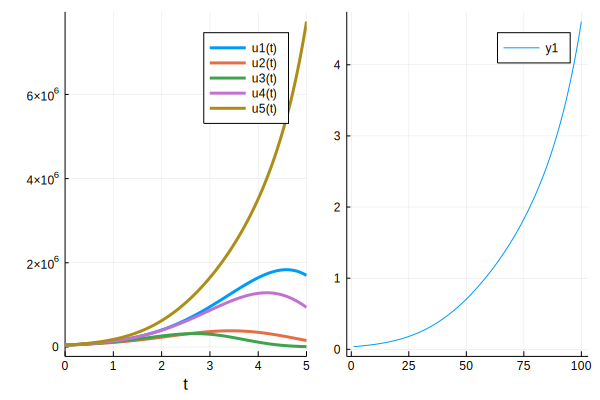

In [33]:
C0 = ones(5).* 215000 / 5
p = param_gen(0.0,"Evolved")
tspan = (0.0,5.0)

prob = ODEProblem(dC!,C0,tspan,p)
sol = solve(prob)

p1 = plot(sol)
p2 = plot(get_resp(sol,100))

plot(p1,p2)

In [32]:
#assign interactions
res = cat(Com_data,fill("Pred_Resp",size(Com_data)[1],1),
                   fill("Pred_Resp_Bio",size(Com_data)[1],1),
                   fill("Biomass",size(Com_data)[1],1)
    , dims = 2)


for i = 1:(size(Com_data)[1]-1)
    
    print("\r",i)
    
    #get parameters
    Treatment = Com_data[i+1,3]
    C0 = ones(5) .* (Com_data[i+1,5] / 5)
    tspan = (0.0,Com_data[i+1,7]/10)
    dT = (1 / (Com_data[i+1,4] * k)) - (1 / (293.15 * k))
    
    p = param_gen(dT , String(Treatment))
    
    prob = ODEProblem(dC!,C0,tspan,p)
    sol = solve(prob)
    
    @assert sol.retcode == :Success

    res[i+1,9] = sum(sol[end] .* p[:R])
    res[i+1,10] = sum((res[i+1,6] / 5) .* p[:R])
    res[i+1,11] = sum(sol[end])
end

writedlm("../data/Simulations/Community_resp.csv",res,',')  

468